Problem based on an illustration from Schmidt 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import pandas as pd

In [2]:
plt.style.use('fivethirtyeight')

# ODE

In [3]:
def odesystem(ca, tau, parameter):

    ea, k0, dhr, cp, cao, to, r, case = p 

    if case == 1:
        # adiabatic mode
        t = to - dhr/cp * (cao - ca) 
    elif case == 2:
        # isothermal mode
        t = to 

    k =  k0 * np.exp(-ea/r/t) 
    rate = - k * ca 
    dtaudCa = 1/rate 

    return dtaudCa

# Data

In [4]:
Ea = 30e3        # Energia de activacion, kcal/mol
k_0 = 2.6e20    # Constante cinetica de referencia min^{-1},
DHr = -20e3     # Calor de reaccion, cal/mol, 
CP = 1000       # Capacidad calorifica cal/L-K,
CAo = 2         # Concentracion inicial, moles/L.
To = 300        # Temperatura de alimentacion, K
R = 1.987207    # Constante universal, cal/mol/K

## Adiabatic mode

In [5]:
# Caso adiabatico
case = 1 
p = [Ea, k_0, DHr, CP, CAo, To, R, case] 
initial_cond = [0] 

CaSpan = np.linspace(CAo, 0.01*CAo, 100) 

fun = lambda Ca, tau: odesystem(Ca, tau, p)
solve = solve_ivp(fun, [CAo, 0.01*CAo], initial_cond, t_eval=CaSpan)

Tau = solve.y[0]
Ca = solve.t

Temps = To - DHr/CP * (CAo - Ca) 

### Profile plots

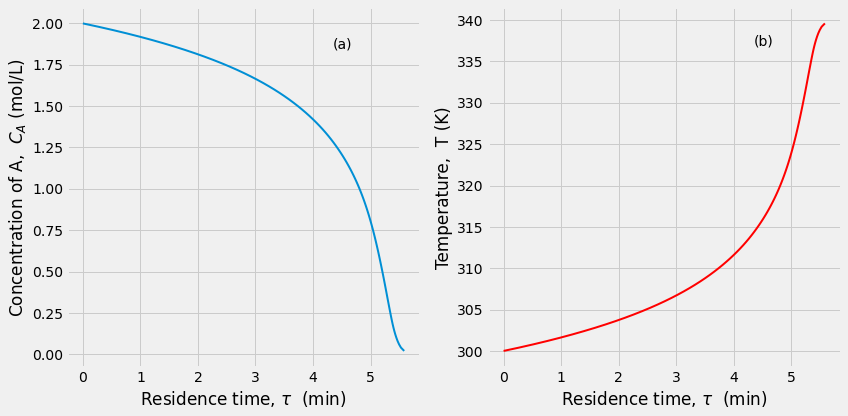

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(Tau, Ca, lw=2)
ax1.set_xlabel('Residence time, $\\tau$  (min)') 
ax1.set_ylabel('Concentration of A,  $C_A$ (mol/L)')
ax1.text(4.35, 1.85, '(a)')
ax2.plot(Tau, Temps, lw=2, color='red')
ax2.set_xlabel('Residence time, $\\tau$  (min)') 
ax2.set_ylabel('Temperature,  T (K)')
ax2.text(4.35, 337, '(b)')
plt.tight_layout()
plt.show()

## Isothermal mode

In [7]:
case = 2 
p[7] = case
 
fun = lambda Ca, tau: odesystem(Ca, tau, p)
solve = solve_ivp(fun, [CAo, 0.01*CAo], initial_cond, t_eval=CaSpan)

Tau_iso = solve.y[0]
Ca_iso = solve.t

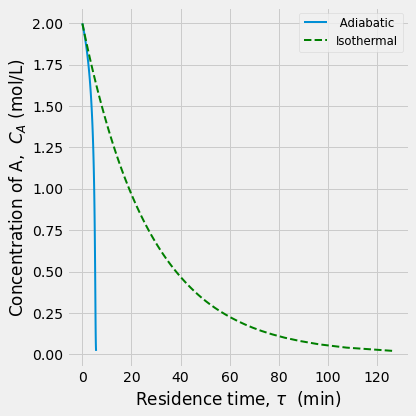

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(Tau, Ca,lw=2, label=' Adiabatic') 
ax.plot(Tau_iso, Ca_iso, 
        lw=2, ls='--', color=[0, 0.498039215803146, 0], 
        label= 'Isothermal') 

ax.set_xlabel('Residence time, $\\tau$  (min)') 
ax.set_ylabel('Concentration of A,  $C_A$ (mol/L)') 

ax.legend(loc=0, fontsize='small')
plt.tight_layout()
plt.show()

## Performance comparison between an adiabatic CSTR and PFR

In [9]:
# Adiabatic CSTR
# Perfil de concentracion
#
Temp_CSTR = To - DHr/CP * (CAo - CaSpan) 
k_T_CSTR = k_0 * np.exp(-Ea/R/Temp_CSTR) 
tau_CSTR = (CAo - CaSpan)/(k_T_CSTR * CaSpan) 

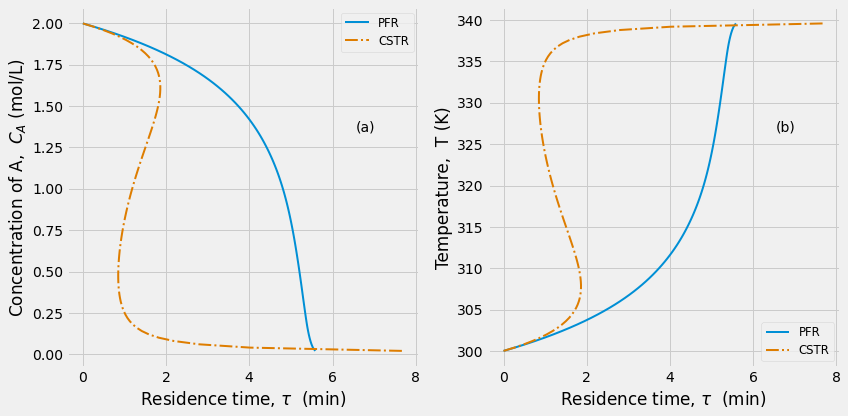

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(Tau, Ca, lw=2, label='PFR')
ax1.plot(tau_CSTR, CaSpan, lw='2', label='CSTR', ls='-.',
        color=[0.87058824300766, 0.490196079015732, 0])
ax1.set_xlabel('Residence time, $\\tau$  (min)') 
ax1.set_ylabel('Concentration of A,  $C_A$ (mol/L)')
ax1.legend(loc=0, fontsize='small')
ax1.text(6.55, 1.35, '(a)')

ax2.plot(Tau, Temps, lw=2, label='PFR')
ax2.plot(tau_CSTR, Temp_CSTR, lw='2', label='CSTR', ls='-.',
        color=[0.87058824300766, 0.490196079015732, 0])
ax2.set_xlabel('Residence time, $\\tau$  (min)') 
ax2.set_ylabel('Temperature,  T (K)')
ax2.legend(loc=0, fontsize='small')
ax2.text(6.55, 326.5, '(b)')
plt.tight_layout()
plt.show()

## Detection of steady-state operating points

In [11]:
tau_ss = 1.5                # this is an arbitrary selection
T_ss = np.linspace(300,340) 
k_ss = k_0 * np.exp(-Ea/R/T_ss)
HWR = CP/tau_ss * (To - T_ss)
CA_ss = CAo * k_ss/(1 + k_ss * tau_ss)
HPR = - CA_ss * DHr
BE = HWR + HPR

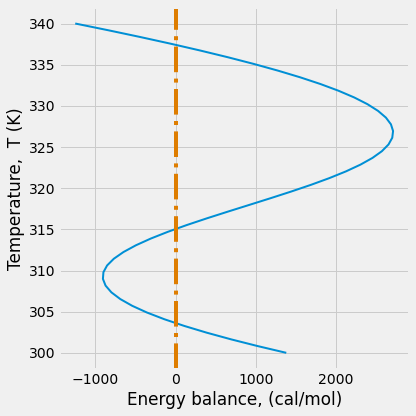

In [12]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(BE, T_ss, lw=2)
ax.axvline(ls='-.', 
           color=[0.87058824300766, 0.490196079015732, 0])

ax.set_xlabel('Energy balance, (cal/mol)')
ax.set_ylabel('Temperature,  T (K)')

plt.tight_layout()
plt.show()

In [13]:
# Energy balance for a CSTR
# Calculating stable operating Temperature at space-time 1.5 min (see last Figure)
function_BE = lambda x: (CP/tau_ss * (To - x) - 
                         CAo * (k_0 * np.exp(-Ea/R/x)) / (1 + k_0 * np.exp(-Ea/R/x) * tau_ss) * DHr)

seeds = [300, 338]

solT = fsolve(function_BE, seeds)

In [14]:
# Calculating the fractional conversion at steady-state
Xss = (1 - (CAo * k_0 * np.exp(-Ea/R/solT) / (1 + k_0 * np.exp(-Ea/R/solT) * tau_ss)) / CAo)

In [15]:
pd.DataFrame(np.vstack((solT,Xss)).T, columns=['Temp', 'XA'])

,Temp,XA
0,303.608016,0.939866
1,337.409655,0.376506


## Calculating the optimum temperature progression

Let's find out for an adiabatic CSTR

In [16]:
# Plotting
y = 1/(k_T_CSTR * CaSpan)
x = CAo - CaSpan

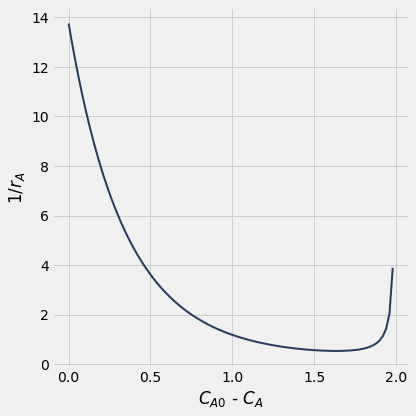

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x,y,lw=2,
        color=[0.152941182255745, 0.227450981736183, 0.372549027204514])

ax.set_xlabel('$C_{A0}$ - $C_A$')
ax.set_ylabel('1/$r_A$')
plt.tight_layout()
fig.savefig('../figures/003_15_07.png')
plt.show()